# 手动实现经典NLP深度学习算法——Transformer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.sequence import load_data, get_vocab
from transformer.transformer import TransformerSeq2seq
from common.optimizer import Adam
from common.utils import Trainer, eval_seq2seq

## Ⅰ、加载日期序列数据集

In [2]:
(x_train, t_train), (x_test, t_test) = load_data('date.txt')
char_to_id, id_to_char = get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 29) (45000, 11)
(5000, 29) (5000, 11)
[ 8 22  9 22  9  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7]
[14 11 12  9  8 15 16  8 15 16  9]
2/7/72                       
_1972-02-07


## Ⅱ、创建Transformer网络模型

In [3]:
# 定义超参数
vocab_size = len(char_to_id)
d_model = 64           # 模型的特征维度（词嵌入维度）
num_heads = 4          # 注意力头的数量（必须能整除d_model）
d_ff = 256             # 前馈网络隐藏层维度（通常是d_model的4倍）
num_layers = 2         # 编码器和解码器的层数
max_len = 100          # 最大序列长度
dropout_ratio = 0.1    # Dropout比率

batch_size = 128
max_epoch = 10
max_grad = 5.0

In [4]:
# 反转输入
is_reverse = True
if is_reverse:
  x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

In [5]:
# 定义模型
model = TransformerSeq2seq(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    num_layers=num_layers,
    max_len=max_len,
    dropout_ratio=dropout_ratio
)
optimizer = Adam()
trainer = Trainer(model, optimizer)

## Ⅲ、模型训练并评估

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.82
| epoch 1 |  iter 21 / 351 | time 9[s] | loss 2.58
| epoch 1 |  iter 41 / 351 | time 18[s] | loss 1.94
| epoch 1 |  iter 61 / 351 | time 25[s] | loss 1.43
| epoch 1 |  iter 81 / 351 | time 33[s] | loss 1.17
| epoch 1 |  iter 101 / 351 | time 42[s] | loss 1.05
| epoch 1 |  iter 121 / 351 | time 49[s] | loss 0.99
| epoch 1 |  iter 141 / 351 | time 57[s] | loss 0.91
| epoch 1 |  iter 161 / 351 | time 64[s] | loss 0.83
| epoch 1 |  iter 181 / 351 | time 72[s] | loss 0.73
| epoch 1 |  iter 201 / 351 | time 79[s] | loss 0.64
| epoch 1 |  iter 221 / 351 | time 86[s] | loss 0.55
| epoch 1 |  iter 241 / 351 | time 93[s] | loss 0.44
| epoch 1 |  iter 261 / 351 | time 101[s] | loss 0.36
| epoch 1 |  iter 281 / 351 | time 109[s] | loss 0.30
| epoch 1 |  iter 301 / 351 | time 116[s] | loss 0.24
| epoch 1 |  iter 321 / 351 | time 123[s] | loss 0.21
| epoch 1 |  iter 341 / 351 | time 130[s] | loss 0.18
Q 10/15/94                     
T 1994-10-15
O 19

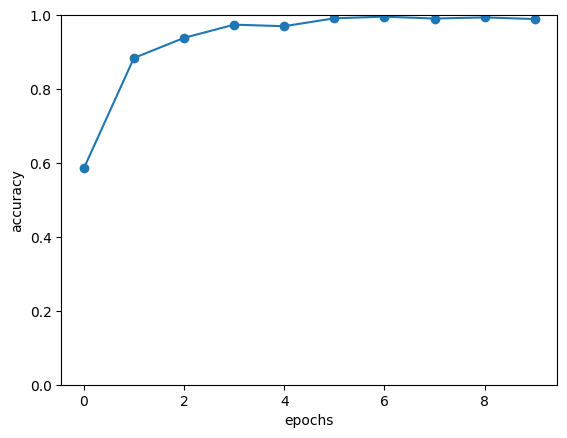

In [6]:
acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse)

  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  print('val acc %.3f%%' % (acc * 100))

x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

## Ⅳ、可视化多头注意力机制

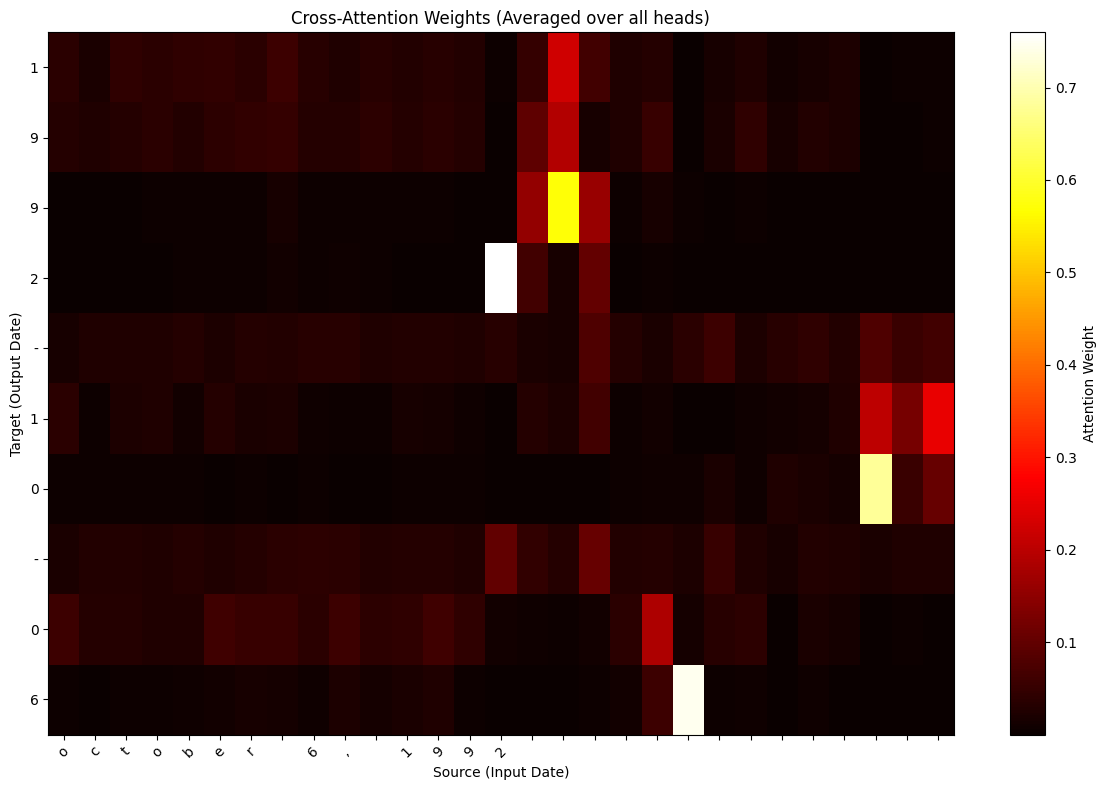

Source: october 6, 1992              
Target: 1992-10-06


In [7]:
# 重新前向传播一个样本
idx = 5
x_sample = x_test[[idx]]
t_sample = t_test[[idx]]

# 前向传播
loss = model.forward(x_sample, t_sample)

# 获取最后一层解码器的交叉注意力
last_decoder_layer = model.decoder.layers[-1]
cross_attn_weights = last_decoder_layer.cross_attention.attention_weights

# 如果是多头注意力合并后的结果 (N*num_heads, T_q, T_k)
# 需要平均或选择某个头
N = 1
num_heads = model.decoder.layers[0].cross_attention.num_heads
T_q = cross_attn_weights.shape[1]
T_k = cross_attn_weights.shape[2]

# 重塑并平均所有头
attn_reshaped = cross_attn_weights.reshape(N, num_heads, T_q, T_k)
attn_avg = attn_reshaped[0].mean(axis=0)  # 平均所有头

# 准备标签
if is_reverse:
    source_labels = [id_to_char[i] for i in x_sample[0][::-1]]
else:
    source_labels = [id_to_char[i] for i in x_sample[0]]
target_labels = [id_to_char[i] for i in t_sample[0][1:]]

# 可视化
plt.figure(figsize=(12, 8))
plt.imshow(attn_avg, cmap='hot', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xticks(range(len(source_labels)), source_labels, rotation=45)
plt.yticks(range(len(target_labels)), target_labels)
plt.xlabel('Source (Input Date)')
plt.ylabel('Target (Output Date)')
plt.title('Cross-Attention Weights (Averaged over all heads)')
plt.tight_layout()
plt.show()

print(f"Source: {''.join(source_labels)}")
print(f"Target: {''.join(target_labels)}")